In [1]:
import json
import itertools
import glob
import os
import io
from collections import defaultdict
import zlib
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import Mask2FormerForUniversalSegmentation
from PIL import Image


from my_utils import greedy_iou, load_segmentation_and_info, show_segmentation, sam_demo, show_img_and_attacker_segment_info


id2label = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic").config.id2label

In [2]:
# load SAM model and mask generator
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "pretrained_checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 11.76 GiB total capacity; 2.36 GiB already allocated; 19.12 MiB free; 2.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Largest Model Discrepancy

sum of ious: [1.11227981 1.12433564 1.18270933 1.18798788 1.23080811 1.2328607
 1.24055854 1.24260758 1.2499419  1.2545165  1.25533922 1.25837396
 1.28036971 1.28565868 1.29219417 1.29441868 1.31637425 1.33143625
 1.34314924 1.36306467]
img_names: ['000000250766', '000000520832', '000000231747', '000000370711', '000000364884', '000000535523', '000000172083', '000000052412', '000000057232', '000000217753', '000000133000', '000000439994', '000000345469', '000000042178', '000000424135', '000000377393', '000000200152', '000000078266', '000000296634', '000000553664']
img_name: 000000250766
sam_oneformer: 0.0309
sam_mask2former: 0.0293
sam_maskformer: 0.0344
oneformer_mask2former: 0.287
oneformer_maskformer: 0.365
mask2former_maskformer: 0.366

img_name: 000000520832
sam_oneformer: 0.0482
sam_mask2former: 0.0473
sam_maskformer: 0.0569
oneformer_mask2former: 0.187
oneformer_maskformer: 0.248
mask2former_maskformer: 0.537

img_name: 000000231747
sam_oneformer: 0.108
sam_mask2former: 0.0367
sam

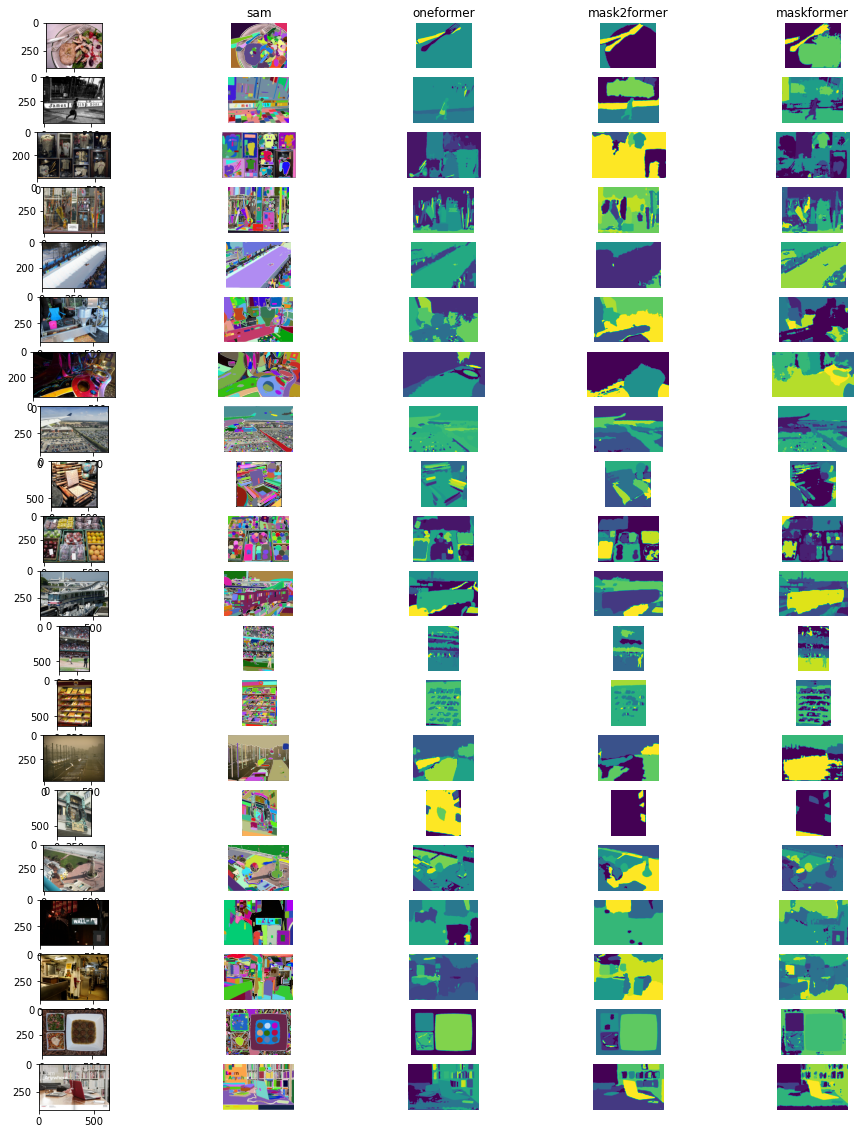

In [7]:
""" Find the imgs with largest model dicrepancy
"""
saved_json_ls = sorted(glob.glob('/home/yjl/data/val2017_similarity/*'))
models = ['sam', 'oneformer', 'mask2former', 'maskformer']
metric = 'greedyiou'
combinations = list(itertools.combinations(models, 2))
sum_iou_ls = []
for saved_json in saved_json_ls:
	with open(saved_json, 'r') as file:
		data = json.load(file)
	sum_iou = 0
	for model1, model2 in combinations:
		try:
			if data[model1+'_'+model2][metric] == -1:
				sum_iou += 1
			else:
				sum_iou += data[model1+'_'+model2][metric]
		except KeyError:
			sum_iou += 1
	sum_iou_ls.append(sum_iou)
# print the minimum N values and their image name
sum_iou_ls = np.array(sum_iou_ls)
idx_ls = sum_iou_ls.argsort()[:10]
print('sum of ious:', sum_iou_ls[idx_ls])
print('img_names:', [os.path.basename(saved_json_ls[i]).split('.')[0] for i in idx_ls])


# show the images
fig, axs = plt.subplots(len(idx_ls), len(models)+1, figsize=(16, 20))

for i, idx in enumerate(idx_ls):
	img_name = os.path.basename(saved_json_ls[idx]).split('.')[0]
	img = Image.open(f'/home/yjl/data/val2017/{img_name}.jpg')
	axs[i, 0].imshow(img)
	info_text = ''
	info_text += 'img_name: '+img_name+'\n'
	# print ious of combinations
	with open(saved_json_ls[idx], 'r') as file:
		data = json.load(file)
	for model1, model2 in combinations:
		info_text += model1+'_'+model2+': '+ '%.3g'%(data[model1+'_'+model2][metric])+'\n'
	# show segmentation results of top performers
	for j, m in enumerate(models, 1):
		show_segmentation(ax=axs[i, j], img_name=img_name, model_name=m, mask_generator=mask_generator, transparency=0, id2label=id2label, legend=False)
	# set row header using ylabel
	# axs[i, 0].set_ylabel(info_text, rotation=0, loc='bottom')
	print(info_text)
for j, m in enumerate(models, 1):
	axs[0, j].set_title(m)
plt.savefig('demo_imgs/model_discrepancy' + metric+'.jpg')

